# Emotion classification using the RAVDESS dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) is licensed under CC BY-NA-SC 4.0. and can be downloaded free of charge at https://zenodo.org/record/1188976.

***Construction and Validation***

Construction and validation of the RAVDESS is described in our paper: Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

The RAVDESS contains 7356 files. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. Validation data is open-access, and can be downloaded along with our paper from PLOS ONE.

***Description***

The dataset contains the complete set of 7356 RAVDESS files (total size: 24.8 GB). Each of the 24 actors consists of three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound).  Note, there are no song files for Actor_18.

***Data***

For this notebook, Audio-Only files have been used (1440 files: 60 trials per actor x 24 actors = 1440.

***License information***

The RAVDESS is released under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License, CC BY-NA-SC 4.0

***File naming convention***

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

***Filename identifiers***

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
- Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 02-01-06-01-02-01-12.mp4 

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement “dogs” (02)
- 1st Repetition (01)
- 12th Actor (12)
- Female, as the actor ID number is even.

# Analysis

We are using Colab, a Google Cloud environment for jupyter, so we need to import our files from Google Drive and then install LibROSA, a python package for music and audio analysis.

After the import, we will plot the signal of the first file.

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!pip install librosa

In [0]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/drive/My Drive/Ravdess/03-01-01-01-01-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


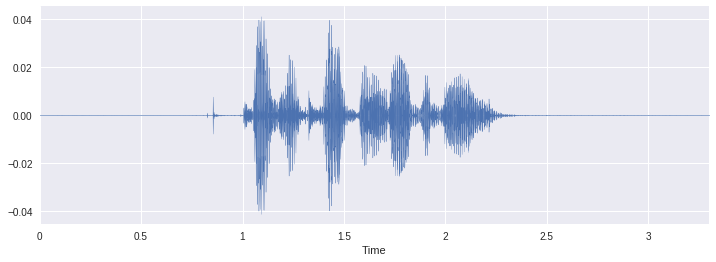

In [0]:
% pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [0]:
path = '/content/drive/My Drive/Ravdess'
lst = []

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        file = file[6:8]
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue       

In [0]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [0]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((1440, 40), (1440,))

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
dtree = DecisionTreeClassifier()

In [0]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
predictions = dtree.predict(X_test)

Let's go with our classification report.

Before we start, a quick reminder of the classes we are trying to predict:

emotions = {
    "neutral": "01",
    "calm": "02",
    "happy": "03",
    "sad": "04",
    "angry": "05", 
    "fearful": "06", 
    "disgust": "07", 
    "surprised": "08"
}

In [0]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

         01       0.29      0.41      0.34        29
         02       0.57      0.60      0.58        70
         03       0.34      0.35      0.35        57
         04       0.33      0.21      0.26        71
         05       0.43      0.44      0.44        59
         06       0.37      0.36      0.37        66
         07       0.39      0.34      0.36        64
         08       0.28      0.35      0.31        60

avg / total       0.38      0.38      0.38       476



Being a multiclass problem (8 classes to predict) and with a little dataset, the result is not that bad.

In particular, we have a starting point for precision/recall tradeoff for the classes Angry, Disgust and Surprised.

# Random Forest

In this second approach, I switched to a random forest classifier and I made a gridsearch to make some hyperparameters tuning.

The gridsearch is not shown in the code below otherwise the notebook will require too much time to run.

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [0]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=22000, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [0]:
predictions = rforest.predict(X_test)

In [0]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

         01       0.00      0.00      0.00        29
         02       0.52      0.91      0.66        70
         03       0.34      0.39      0.36        57
         04       0.45      0.24      0.31        71
         05       0.59      0.61      0.60        59
         06       0.53      0.47      0.50        66
         07       0.44      0.42      0.43        64
         08       0.48      0.55      0.51        60

avg / total       0.45      0.48      0.45       476



We have an improvement: what we see is that the class "Angry" is the easiest to predict at the moment.

# Neural network

We are going to do 2 actions: 

1) Expand the dimensions of our array, adding a third one (this is necessary for the Neural Network);

2) Build our network.

In [0]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [0]:
x_traincnn.shape, x_testcnn.shape

((964, 40, 1), (476, 40, 1))

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix


model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

With *model.summary* we can see a recap of what we have build:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 40, 256)           1536      
_________________________________________________________________
activation_98 (Activation)   (None, 40, 256)           0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 40, 128)           163968    
_________________________________________________________________
activation_99 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 5, 128)            0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 5, 128)            82048     
__________

Now we can compile and fit our model:

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [0]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=250, validation_data=(x_testcnn, y_test))

Train on 964 samples, validate on 476 samples
Epoch 1/250
964/964 [==============================] - 4s 4ms/step - loss: 2.4359 - acc: 0.1380 - val_loss: 2.0489 - val_acc: 0.1660
Epoch 2/250
964/964 [==============================] - 2s 2ms/step - loss: 2.1881 - acc: 0.1473 - val_loss: 2.0632 - val_acc: 0.1492
Epoch 3/250
964/964 [==============================] - 2s 2ms/step - loss: 2.1089 - acc: 0.1774 - val_loss: 2.0121 - val_acc: 0.1744
Epoch 4/250
964/964 [==============================] - 2s 2ms/step - loss: 2.0895 - acc: 0.1826 - val_loss: 1.9944 - val_acc: 0.2185
Epoch 5/250
964/964 [==============================] - 2s 2ms/step - loss: 2.0863 - acc: 0.1732 - val_loss: 2.0030 - val_acc: 0.1513
Epoch 6/250
964/964 [==============================] - 2s 2ms/step - loss: 2.0510 - acc: 0.2054 - val_loss: 1.9460 - val_acc: 0.2752
Epoch 7/250
964/964 [==============================] - 2s 2ms/step - loss: 2.0281 - acc: 0.2085 - val_loss: 1.9968 - val_acc: 0.1912
Epoch 8/250
964/964 [==

Let's plot the loss:

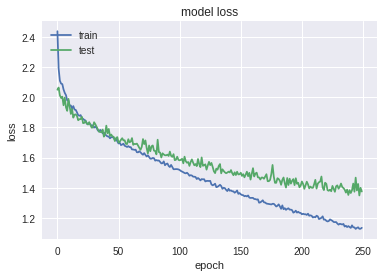

In [0]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Observations

As you can see from the graph above, after 150 epochs the model starts to overfit: the training set converges to the minimum more quickly that the test set.

It seems also that the test set stops converging at more or less 200 epochs.

If we add more epochs to the network, the result will be a great increment of the accuracy on the training set without a significant improvement on the test set.

Overfitting means that the model tends to be accurate only with the data we are using for the training.

Now we can save our model:

In [0]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 


# Thanks for reading: to be continued...